In [2]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch import nn
import pytorch_lightning as L
from pytorch_lightning import seed_everything, LightningModule, Trainer
import numpy as np

In [3]:
data_dir = '/Volumes/Data/Row_Data'
file_name  = 'kpx_powerDemand_2013_2023_v3.csv'
url = f'{data_dir}/{file_name}'
df_data = pd.read_csv(url, parse_dates=['date_time'], index_col="date_time")  
df_data

,demand,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,temp
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,60178,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2013-01-01 01:00:00,57862,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2013-01-01 02:00:00,56165,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2013-01-01 03:00:00,55135,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2013-01-01 04:00:00,54450,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,62902,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1
2023-12-31 20:00:00,62061,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,1
2023-12-31 21:00:00,61403,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1


In [4]:
scaler = MinMaxScaler()
scaler.fit( df_data[['demand']] )

MinMaxScaler()

In [5]:
#(24 Hour * 30 Day)
window_size = 720

In [6]:
class PowerDemandVolumeDataset(Dataset):
    
    def __init__(self, df_data, data_type , transformer, window_size=window_size):

        self.type = data_type
        self.transformer = transformer
        # window_size= 720 #(24 Hour  * 30Day)
        self.window_size = window_size
        self.df_data = df_data

        self.data = self.getData()
        
        features = self.data
        target = self.data.demand
        
        self.x, self.y = [], []


        # 각 시간간격별 예측시  1시간뒤: x = 0 , 2시간뒤: x = 1, 3시간뒤: x = 2 ...
        #
        # for i in range(len(features) - self.window_size - X):
        #     v = features.iloc[ i: (i + window_size) ].values
        #     self.x.append(v)
        #     self.y.append( target.iloc[ i + window_size + x] )

        
        for i in range(len(features) - self.window_size ):
            v = features.iloc[ i: (i + window_size) ].values
            self.x.append(v)
            self.y.append( features.iloc[ i + window_size ]['demand'] )
            #self.y.append( target[ i + window_size ] )


        # Many to Many output_size = 6
       # for i in range(len(features) - self.window_size - 6 + 1):
       #     self.x.append( features.iloc[ i: (i + window_size) ].values )
       #     a = target[  i + window_size :  i + window_size + 6].values.reshape(-1, 1)
       #     self.y.append( a)
    

    def getData(self):

        if self.type == 'train':
            df_data = self.df_data.loc['2013-01-01':'2020-12-31']
            df_data.demand =  self.transformer.transform(df_data[['demand']])
            return df_data
        elif self.type == 'valid':
            df_data = self.df_data.loc['2020-01-01':'2022-12-31']
            df_data.demand =  self.transformer.transform(df_data[['demand']])
            return df_data
        elif self.type == 'test': 
            df_data = self.df_data.loc['2023-01-01':'2023-12-31']
            df_data.demand =  self.transformer.transform(df_data[['demand']])
            return df_data
        else:
            df_data = self.df_data
            df_data.demand =  self.transformer.transform(df_data[['demand']])
            return df_data
    
    
    def __getitem__(self, index):
        
        x = self.x[index].astype(np.float32)
        y = self.y[index].astype(np.float32)
        return x, y
    
        
        
    
    def __len__(self):
        
        return len(self.x)

In [7]:
input_size =45
batch_size=100
learning_rate=0.0001
log_path = os.getcwd()
device = torch.device("mps") if torch.backends.mps.is_available() else  torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print(f'Device:{device}, Number of workers:{NUM_WORKERS}\nCurrent Dir:{log_path}')

Device:mps, Number of workers:8
Current Dir:/Volumes/WorkSpace/PythonProjects/timeSerise


In [8]:
test_data = PowerDemandVolumeDataset(df_data=df_data, data_type='test', transformer=scaler,  window_size=window_size)
#let's loop it over single iteration and print the shape and also data
for i, (features,targets) in enumerate(test_data):
    print("Size of the features",features.shape)
    print("Printing features:\n", features)
    print("Size of the targets",targets.shape)
    print("Printing targets:\n", targets)
    break

/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_10518/4046016201.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.demand =  self.transformer.transform(df_data[['demand']])


Size of the features (720, 45)
Printing features:
 [[0.48199946 1.         0.         ... 0.         0.         1.        ]
 [0.44007826 1.         0.         ... 0.         0.         1.        ]
 [0.41011736 1.         0.         ... 0.         0.         1.        ]
 ...
 [0.67333037 1.         0.         ... 0.         0.         1.        ]
 [0.6700014  1.         0.         ... 1.         0.         1.        ]
 [0.66288006 1.         0.         ... 0.         1.         1.        ]]
Size of the targets ()
Printing targets:
 0.5984796


In [9]:
#num_worker = 1
train_loader = DataLoader( PowerDemandVolumeDataset(df_data=df_data, data_type='train', transformer=scaler), batch_size=batch_size)
valid_loader = DataLoader( PowerDemandVolumeDataset(df_data=df_data, data_type='valid', transformer=scaler), batch_size=batch_size)
test_loader = DataLoader( PowerDemandVolumeDataset(df_data=df_data, data_type='test', transformer=scaler), batch_size=batch_size)


/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_10518/4046016201.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.demand =  self.transformer.transform(df_data[['demand']])
/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_10518/4046016201.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.demand =  self.transformer.transform(df_data[['demand']])
/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_10518/4046016201.py:53: SettingWithCopyWarning: 
A value is try

In [48]:
class PowerDemandPrediction(L.LightningModule):
    def __init__(self, input_size=input_size, output_size=1, hidden_dim=10, n_layers=2, lr=learning_rate, window_size=window_size):
 
        super(PowerDemandPrediction, self).__init__()


        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim * window_size, output_size)
        self.loss = nn.MSELoss()
        self.flatten = nn.Flatten()
        self.learning_rate = lr

    

    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)    
        lstm_out, (hidden, cell) = self.lstm(x, hidden)
        out = self.flatten(lstm_out)
        out = self.fc(out)

        return out

    
    
    def init_hidden(self, batch_size):   
        hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        hidden = (hidden_state, cell_state)
        return hidden

    
    
    def configure_optimizers(self):
        return {'optimizer': torch.optim.Adam(params=self.parameters(), lr = self.learning_rate) }

    def training_step(self, train_batch, batch_idx):
        features, targets = train_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('train_loss', loss, prog_bar=True)
        return {"loss": loss}
        
    
    def validation_step(self, val_batch, batch_idx):
        features, targets = val_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('val_loss', loss, prog_bar=True)



In [49]:
model = PowerDemandPrediction().to(device)
model

PowerDemandPrediction(
  (lstm): LSTM(45, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7200, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [50]:
trainer = L.Trainer( fast_dev_run=True, accelerator='mps', devices=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [51]:
trainer = L.Trainer( default_root_dir=log_path, precision="16", max_epochs=20, accelerator='mps', devices=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning_fabric/connector.py:571: UserWarning:

`precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!

Using 16bit Automatic Mixed Precision (AMP)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [52]:
trainer.fit( model, train_loader,  valid_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 3.2 K  | train
1 | fc      | Linear  | 7.2 K  | train
2 | loss    | MSELoss | 0      | train
3 | flatten | Flatten | 0      | train
--------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.041     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                            | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Training: |                                                                   | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [53]:
PATH = '/Volumes/WorkSpace/PythonProjects/timeSerise/lightning_logs/version_14/checkpoints/epoch=19-step=13900.ckpt'
model = PowerDemandPrediction.load_from_checkpoint(PATH).to(device)
model.eval()

PowerDemandPrediction(
  (lstm): LSTM(45, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7200, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [54]:
predicted_result, actual_result = [], []

for i, (features,targets) in enumerate(test_loader):

    features = features.to(device)
    targets = targets.to(device)

    result = model(features)
    predicted_result.extend(result.view(-1).tolist())
    actual_result.extend(targets.view(-1).tolist())

In [55]:
df_before = df_data.loc['2023-01-30':'2023-12-30']['demand']
df_before.index = pd.date_range('2023-01-31 00:00:00', '2023-12-31 23:00:00', freq='1h')
df_before

2023-01-31 00:00:00    65069
2023-01-31 01:00:00    62933
2023-01-31 02:00:00    61792
2023-01-31 03:00:00    61302
2023-01-31 04:00:00    62034
                       ...  
2023-12-31 19:00:00    64934
2023-12-31 20:00:00    63817
2023-12-31 21:00:00    62436
2023-12-31 22:00:00    63010
2023-12-31 23:00:00    62981
Freq: h, Name: demand, Length: 8040, dtype: int64

In [56]:
actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
inverse_transformed_values = scaler.inverse_transform(actual_predicted_df)
#inverse_transformed_values = model.transformer.inverse_transform(actual_predicted_df)
actual_predicted_df["actual"] = inverse_transformed_values[:,[0]]
actual_predicted_df["predicted"] = inverse_transformed_values[:,[1]]

# window_size= 720 #(24 Hour  * 30Day) 을 뺀 일수 
actual_predicted_df.index = pd.date_range('2023-01-31 00:00:00', '2023-12-31 23:00:00', freq='1h')

actual_predicted_df['before'] = df_before
actual_predicted_df

,actual,predicted,before
2023-01-31 00:00:00,71109.998834,52668.516963,65069
2023-01-31 01:00:00,68704.999390,50185.035933,62933
2023-01-31 02:00:00,67449.999146,49045.135125,61792
2023-01-31 03:00:00,66689.999856,48792.308005,61302
2023-01-31 04:00:00,66998.000372,49447.459085,62034
...,...,...,...
2023-12-31 19:00:00,62901.999208,65523.952992,64934
2023-12-31 20:00:00,62060.999162,65507.155048,63817
2023-12-31 21:00:00,61402.999795,64925.434186,62436
2023-12-31 22:00:00,61890.999869,64715.732557,63010


In [57]:
df_data.demand.min(), df_data.demand.max()

(np.int64(36233), np.int64(94509))

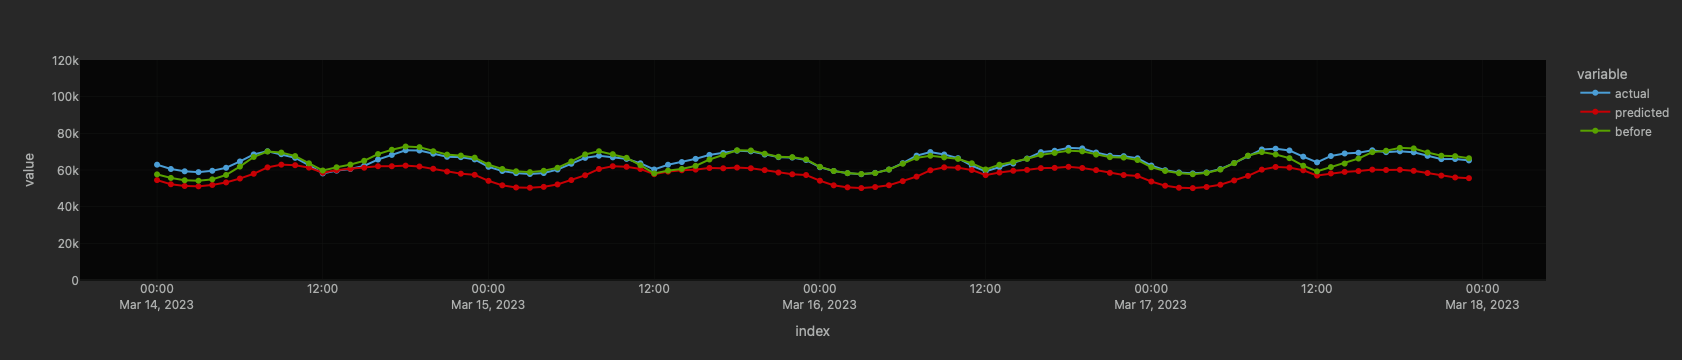

In [65]:
import plotly.express as px
from dash_bootstrap_templates import load_figure_template
load_figure_template(["minty",  "minty_dark", 'cyborg', 'cyborg_dark'])

start_date = '2023-03-14'
end_date = '2023-03-17'

data = actual_predicted_df.loc[start_date:end_date]
fig = px.line( data[['actual', 'predicted', 'before']], markers=True, template='cyborg', height=600)
fig.update_layout(yaxis_range=[0, 120000])
fig.show()